# Exercise Group - Chapter 1 and 2

Below you find exercises for end of Chapter 1 and the start of Chapter 2. These exercises will prepare you in particular for the obligatory mid-term tests. The purpose of the prepared code snippets below is to give you some helpful structure for coding by predefining some useful variable names, but you do not need to use these prepared code snippets and prepared variable names if you do not want to. Do not hestitate to use the function `help()` to print the documentation of the functions that you need. If you are stuck, please ask one of the supervisors present.

In the shared folder you will find a subfolder `data` containing important time series. You may copy them to your "*my_materials*" folder in order to import the data from there if you like.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
os.getcwd()

'/home/jovyan/my_materials'

After running the import-statements above there should be a line displayed with `'/home/jovyan/my_materials'.`

The code below computes the one-day-ahead-VaR for the DAX time series, which we will need in the following exercise. Calculations are based on the assumption of normally distributed log-returns. The mean and standard deviation of the normal distribution are computed from the last trading year for different levels $\alpha$.

In [3]:
dax_data = np.loadtxt('../shared_materials/data/DAX_index.csv', skiprows=1, usecols=1, delimiter=',')

def log_returns(data):
    return np.diff(np.log(data))

def VaR_log_normal(s, alpha):
    lr_dax = log_returns(s) #risk factors
    mu = np.mean(lr_dax)
    sigma = np.std(lr_dax)
    return s[-1] * (1 - np.exp(-sigma * stats.norm.ppf(alpha) + mu))

td = 252 #trading days
alpha = np.array([0.9, 0.95, 0.975, 0.99]) #intervals
VaR = np.zeros((len(alpha), len(dax_data) - td))
for j in range(len(alpha)):
    for i in range(len(dax_data) - td):
        VaR[j, i] = VaR_log_normal(dax_data[i:i + td], alpha[j])

In [4]:
# Output data
VaR.shape

(4, 6058)

In [5]:
dax_data

array([ 6750.76,  6586.95,  6502.07, ..., 19254.93, 19210.9 , 19373.83])

<br><br>

# Topic 1: Backtesting the Value-at-Risk for the DAX

## Step 1: Visual Backtesting

To complete this exercise, start by running the code provided above. Next, we aim to verify whether the calculated VaR is performing as expected.

**Task 1.1**: Calculate the actual losses of the dax time series.

*Useful Python commands*: `np.diff`

In [309]:
losses = -np.diff(dax_data)
print(len(losses)-td, len(VaR[0]))

6057 6058


**Task 1.2**: Plot the different levels of VaR against the actual losses of the dax timeseries.

*Useful Python commands*: `plt.plot`

In [310]:
# "new" x-axis for our data --> first year used to calculates; shifting the x-axis
help_array = np.arange(252, len(dax_data))

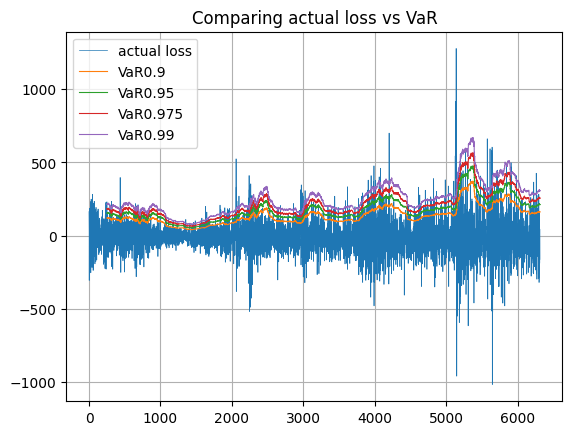

In [311]:
plt.plot(losses, label="actual loss", linewidth="0.5")
for i in range(len(alpha)):
    plt.plot(help_array, VaR[i], label=f"VaR{alpha[i]}", linewidth="0.8")
plt.title('Comparing actual loss vs VaR')
plt.legend()
plt.grid()
plt.show()

Now, examine your plot and consider the following questions. Once you got your own answer, you may reveal the answers below.

(1) What do you notice? Do the Value-at-Risk measures perform well? Is there a specific level $\alpha$ that outperforms the others?
<details>
  <summary>Answer:</summary>

Compared to e.g. the risk measure from Week 1, Task 3.4, the Value-at-Risk with mean and standard deviation computed only from the past trading year adapts much better to periods of high and low volatility. Nevertheless, the Value-at-Risk risk measure always "lags behind" a certain amount of time in adapting to high stress periods in markets. On a quantitative level, the plot alone doesn’t allow us to determine whether the VaR measure is performing well.
</details><br>

(2) Why might it be more appropriate to base the calculation above on the most recent 252 trading days rather than on the entire time series?

<details>
<summary>Answer:</summary>
Using the entire dataset may overlook potential structural changes in the underlying time series. It imposes the assumption of stationarity on the distribution of the log-returns which clearly does not hold in reality since it exhibits periods of higher and of lower volatility.
</details>


In [312]:
# Answer1:
# Its basically an average so its lagging in terms of forecasting the lossses --> loss accured and then its included inside the model.
# The lower the interval the higher the VaR level ... no measurement how to measure the VaR

# Answer2:
# - Thats also how we usually work in risk management.
# - no model error --> see if it fits the data
# --> structural changes not captured (changes over time)

## Step 2: Mathematical Backtesting

Step 1 highlights why a more rigorous mathematical approach to backtesting is essential; from the plot alone, it’s unclear if the computed VaR is effective.

Lemma 1.10 provides the foundation for this mathematical approach to backtesting the VaR. How could the result of Lemma 1.10 be used for backtesting?

<details>
  <summary>Answer:</summary>

  Lemma 1.10 indicates that VaR exceedences should be independent and quantifies the expected number of exceedences: for a 95% VaR, we expect 100%−95%=5% exceedances. If we observe significantly more or fewer exceedences, this suggests our model or method may need adjustment. But what does “more” or “fewer” mean in this context? How much deviation from the expected exceedences is acceptable?
        <details>
              <summary>Answer:</summary>
              The relative frequency of exceedences should lie within a confidence interval. A 95% confidence interval for the exceedence frequency of the 99%-VaR is for example an interval around the number $1 - 0.99 = 0.01$ of which we can be certain with a 95% probability that the losses of the underlying time series exceed the 99%-VaR with a frequency that lies within the interval. If the actually observed number of exceedences in the past happens to lie outside of the interval, this indicate a problem with the model or similar issues.
          </details>
</details>

<br>

**Task 1.3**: How many exceedences of the VaR risk measures plotted in Task 1.2 do you expect, and how many do you actually observe? Interpret your results.

*Useful Python commands*: `np.mean`

In [313]:
# $$ Reference:  Lemma 1.10 - Skript p.17

In [314]:
# Get violation data
expected_violations = (1-alpha)

In [315]:
# Compare levels
for i in range(len(alpha)):
    actual_violations = np.mean(VaR[i, :-1] < losses[td:])
    print(f"For {alpha[i]}-level we have: {round(expected_violations[i], 3)*100}% (exp) vs {round(actual_violations, 3)*100}% (actual)")
    
# The smaller the interval. The more we underestimate our risk.

For 0.9-level we have: 10.0% (exp) vs 9.6% (actual)
For 0.95-level we have: 5.0% (exp) vs 6.2% (actual)
For 0.975-level we have: 2.5% (exp) vs 3.9% (actual)
For 0.99-level we have: 1.0% (exp) vs 2.1% (actual)


#### Create "sample" for Step 3

In [316]:
# Sample matrix for Step 3: (absolute values)
v_sample = np.zeros((len(alpha), len(dax_data) - td))

# Loop for every VaR-Level
for i in range(len(alpha)):
    v_sample[i] = VaR[i] < losses[td-1:]

In [317]:
# Test sample
for i in range(len(v_sample)):
    print(sum(v_sample[i]))

sample_length = len(v_sample[0])
sample_length

585.0
374.0
231.0
137.0


6058

## Step 3: Design a Statistical Test

Assume that we have a sample $ν = (ν_1, ..., ν_m) \in \{0, 1\}^m$ of i.i.d. random variables with $P(ν_1 = 1) = p \in [0, 1]$ where $p$ is unknown. Hence, their sum $\sum^m_{k=1} v_k$ follows a $\mathrm{Bin}(m, p)$-distribution, i.e. a binomial distribution with $m$ experiments and success probability $p$.

A statistical test is a method used to determine whether there is enough evidence in a sample to support a specific hypothesis about a population. It involves comparing observed data against a null hypothesis (typically suggesting no effect or difference) and calculating a test statistic that reflects the difference between the observed data and expectations under the null hypothesis. We would like to test whether $p=p_0$ at some confidence level $\beta$, i.e. we want to test whether the sample $v_1, \dots, v_m$ contains enough evidence to support the hypothesis that the unknown true parameter $p$ is equal to some given $p_0$ with a confidence of 95%.

Why does a two-sided test make more sense in the risk management context of backtesting the VaR than a one-sided test?

*Hint*: In a statistical test, "two-sided" means that the test checks for significant deviations in both directions from the null hypothesis.

<details>
    <summary>Answer:</summary>
    It’s important to check whether the VaR is too lenient, resulting in more violations than expected, or too strict, which would lead to overestimating the risk and indicate a poor model fit. The first problem would result in too few reserved capital, the second problem would result in too much reserved capital from the point of view of a risk management department.
</details>

<br>

**Task 1.4**: Write a function `boundaries(beta, m, p_0)` that returns the lower and upper boundary of a two-sided confidence interval at level $\beta$ for the $\mathrm{Bin}(m, p_0)$ distribution, i.e. an interval $[\ell_l, \ell_u]$ that contains a $\mathrm{Bin}(m, p_0)$-distributed random variable with a probability of $\beta$.

*Useful Python commands*: The $\beta$-quantile of the $\mathrm{Bin}(m, p_0)$ distribution can be accessed via `scipy.stats.binom.ppf(beta, m, p0)`.

In [318]:
# $$ Reference: Lecture Notes P.17/18 Lemma 1.10
#        Independence of Exceedences of VaR levels,
#        construct the two-sided confidence interval

In [319]:
def get_bin_boundaries(beta, m, p0):
    # m: number of tries
    # p: "winning" probability - different for every alpha
    # q: lower tail probability
    
    # different betas
    beta_lower = (1-beta) / 2
    beta_upper = 1-beta_lower

    # Get bounds
    lower_bound = stats.binom.ppf(beta_lower, m, 1-p0)
    upper_bound = stats.binom.ppf(beta_upper, m, 1-p0)
    return lower_bound, upper_bound

In [320]:
# Test bounds
test = get_bin_boundaries(0.99, len(v_sample[0]), 0.99)
test[0], test[1]

(np.float64(42.0), np.float64(81.0))

**Task 1.5**: Design a two sided statistical test at significance level $\beta \in (0, 1)$ for the null hypothesis $H_0 : p = p_0$ and implement this test.
This test is supposed to return the value 1 if the null hypothesis is rejected, and 0 otherwise.

In [323]:
def test_binomial(v, p0, beta):
       """test whether the sample v contains enough evidence to support
       the hypothesis that the unknown true parameter p is equal to
       some given p0 with a certain confidence (of 95%). 
       
       """
       # H0 = rejected: 1
       # H1 = not rejected: 0
    
       actual_p = sum(v)
       sample_length = len(v)
    
       # Get bounds
       [b_lower, b_upper] = get_bin_boundaries(beta, sample_length, p0)
        
       # Check VaR-levels (watch out!!! Use the accepted range not outlier)
       if actual_p <= b_lower or actual_p >= b_upper:
           result = 1 #reject H0
       else:
           result = 0 #not reject
        
       return result, b_lower, b_lower

**Task 1.5**: Apply this test at the level $\beta=0.99$ to the different levels of VaR of the DAX data. What do you observe? How large do you need to choose $\beta$ such that none of the hypotheses is rejected?

In [324]:
# Set parameter
beta = 0.99 # stays constant

# Get results
for i in range(len(alpha)):
    [result, b0, b1] = test_binomial(v_sample[i], alpha[i], beta)
    print(f"Test result for VaR-{alpha[i]}: {result}; lower bound: {b0}; upper bound: {b1}; no. outlier: {sum(v_sample[i])}")

Test result for VaR-0.9: 0; lower bound: 546.0; upper bound: 546.0; no. outlier: 585.0
Test result for VaR-0.95: 1; lower bound: 260.0; upper bound: 260.0; no. outlier: 374.0
Test result for VaR-0.975: 1; lower bound: 121.0; upper bound: 121.0; no. outlier: 231.0
Test result for VaR-0.99: 1; lower bound: 42.0; upper bound: 42.0; no. outlier: 137.0


<br><br>

# Topic 2: Expected Shortfall as a Risk Measure

**Task 2.1**: Write a function `ES(s, alpha, mu, sigma)` that computes the Expected Shortfall at level $\alpha$ for a loss of the form $L_{n+1} = s(1 - e^X)$ with $X \sim N(\mu, \sigma^2)$ as in Example 1.15 using equation (1.10) from the lecture notes.

*Useful Python commands*: `np.exp`. The standard normal cdf $\Phi$ and inverse cdf $\Phi^{-1}$ can be accessed via  `scipy.stats.norm.cdf(...)` `scipy.stats.norm.ppf(...)`, respectively.

In [270]:
def get_ES(s, alpha, mu, sigma):
    return  s[-1] * (1 - (np.exp(mu + (sigma**2)/2)) / (1-alpha) * stats.norm.cdf(-stats.norm.ppf(alpha) - sigma))

**Task 2.2**: Apply this function at the level $\alpha=0.95$ to the DAX time series like for the Value-at-Risk in the provided code snippet above Topic 1, i.e. the estimation of $\mu$ and $\sigma$ should be based on the last 252 trading days. (rolling returns, same as VaR)

In [22]:
# Set parameters
td = 252
alpha = 0.95

In [23]:
# Get ES
ES = np.zeros((len(dax_data) - td))

for i in range(len(dax_data) - td):
    lr_252 = log_returns(dax_data[i:i + td]) #very important property!!!
    mu = np.mean(lr_252)
    sigma = np.std(lr_252)
    
    ES[i] = get_ES(dax_data[i:i + td], alpha, mu, sigma)
ES

array([191.77245971, 189.01111018, 189.8901677 , ..., 267.70018219,
       270.64162924, 270.3732025 ])

**Task 2.3**: Plot the actual losses, the $VaR_{95\%}$ and the $ES_{95\%}$ in a common plot. What do you observe?

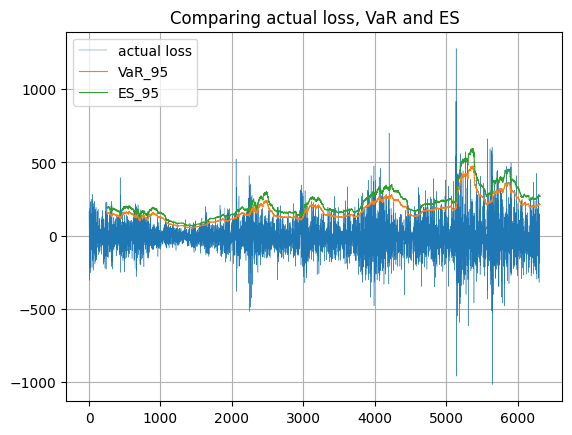

In [24]:
plt.plot(losses, label="actual loss", linewidth=0.3)
plt.plot(help_array, VaR[1], label="VaR_95", linewidth=0.8)
plt.plot(help_array, ES, label="ES_95", linewidth=0.8)

plt.title("Comparing actual loss, VaR and ES")
plt.grid()
plt.legend()
plt.show()

Do you know a similar result as Lemma 1.10 for the Expected Shortfall? How would you test it?

In [25]:
# Answer:
# there is none which is a big issue in terms of comparing different methods.

<br><br>

# Topic 3: Variance-Covariance Method

We now want to calculate the VaR for the portfolio from Week 1, Topic 2 using the Variance-covariance method. 

Consider a stock portfolio $(V_n)_{n \in \{0, \dots, N\}}$ with [4, 8, 15, 16, 23] shares of the German stocks [BMW, SAP, Volkswagen, Continental, Siemens] and suppose that you use logarithmic prices $Z_{n, i} = \log S_{n, i}$ as risk factors. For simplicity, we suppose that the risk factor changes $X_{n+1, i} = \log\big( \frac{S_{n + 1, i}}{S_{n, i}}\big)$ (i.e. the logarithmic returns of the stocks) are iid normally distributed. In this case, the linearised loss has the form $L_{n+1}^{\Delta} = -\sum_{i=1}^5 \alpha_i S_{n, i} X_{n+1, i}$ (see Section 1.2.3).

In [26]:
companies = np.loadtxt('../shared_materials/data/DAX_companies.csv', skiprows=1, usecols=[1, 2, 3, 4, 5], delimiter=',')

In [27]:
# Set parameters
alpha_weights = [4, 8, 15, 16, 23]
alpha = 0.99
data_container = np.zeros(len(companies)-td)
td = 252

# Risk factors
S_n = np.log(companies)
X_n = np.diff(S_n, axis=0) #important property row-wise differences

# Portfolio
weighted_port = alpha_weights * companies

In [28]:
# Function loss operator
def l(n, x):
    return -np.dot(weighted_port[n,:], np.exp(x[n,:])-1)

# Lin. loss operator
def l_delta(n, x):
    return -np.dot(weighted_port[n,:], x[n,:])

In [29]:
# Get losses
losses = np.zeros(len(X_n))

for i in range(len(X_n)):
    losses[i] = l(i, X_n)
losses

array([ 115.3806,   89.7315,   -2.1888, ..., -204.04  ,   52.5   ,
        -73.84  ])

In [30]:
# Get lin losses
losses_delta = np.zeros(len(X_n))

for i in range(len(X_n)):
    losses_delta[i] = l_delta(i, X_n)
losses_delta

array([ 117.87941213,   93.36965531,   -1.77858768, ..., -200.40495814,
         52.6722272 ,  -73.26855834])

<br><br>

## Step 1: Set up the Variance-Covariance Method [p.26]

**Task 3.1**: Define an array `w` and an array `c` that contains the constants $w_n \in \mathbb{R}^5$ and $c_n \in \mathbb{R}$ for each $n \geq 252$. Accordingly, `w` should have shape `(N - 252, 5)` and `c` should have shape `(N - 252, )`.

In [31]:
# Define constants | Ref. [2.1.1.]

w = weighted_port[td:, :] #  wn=(alpha*Sn), portfolio weights starting at 252 days
c = data_container # here c=0

print(w.shape, c.shape)

(6113, 5) (6113,)


**Task 3.2**: For each $n \geq 252$, compute the mean and covariance estimates $\widehat \mu \in \mathbb{R}^5$ and $\widehat \Sigma \in \mathbb{R}^{5 \times 5}$ as in Section 2.2. However, each estimate should only be computed using the previous 252 time steps instead of the whole history of past data, as in the lecture notes. Store your estimates in an array `mu_hat` of shape `(N - 252, 5)` and in an array `Sig_hat` of shape `(N - 252, 5, 5)`.

*Useful Python commands*: `np.mean`, `np.cov`

In [32]:
# Set intital data-chunks
mu_hat = np.zeros((len(companies) - td, len(companies[0])))
sig_hat = np.zeros((len(companies) - td, len(companies[0]), len(companies[0])))

print(mu_hat.shape, sig_hat.shape)


(6113, 5) (6113, 5, 5)


In [33]:
# Get (rolling) mean and covariances
for i in range(len(data_container)):
    for j in range(len(companies[0])):
        mu_hat[i, j] = np.mean(X_n[i:i+td, j])

for i in range(len(data_container)):
    sig_hat[i] = np.cov(X_n[i:i+td], rowvar=False) #rowvar important otherwise every row different variable

print(mu_hat.shape, sig_hat.shape)

(6113, 5) (6113, 5, 5)


#### Testing different parts

In [34]:
# Part 1 
-(np.dot(np.transpose(w[0]), mu_hat[0]))

np.float64(-0.03703383238401681)

In [35]:
# Part 2
np.dot(np.dot(np.transpose(w[1]), sig_hat[1]), w[1]) #--> way to high

np.float64(5413.895693021734)

In [36]:
# Part 3
stats.norm.ppf(alpha)

np.float64(2.3263478740408408)

<br><br>

## Step 2: Compute VaR and ES Estimates

**Task 3.3**: For each $n \geq 252$, compute the VaR estimate $\widehat{\mathrm{VaR}_{0.99}}(L_{n+1}^{\Delta})$ using equation (2.2) in the lecture notes. Store your VaR estimates in an array `VaR`. Accordingly, it should have length `N - 252`.

*Useful Python commands*: `np.sqrt`. The `alpha`-quantile and the density of a standard normal distribution can be accessed by the `scipy` commands `norm.ppf(alpha)` and `norm.pdf()`, respectively.

In [37]:
VaR_vcm = np.zeros(len(data_container)) # [Ref. 2.2.] - replaced moments by sample moments

for i in range(len(data_container)):
    first_part = -(c[i] + np.dot(w[i].T, mu_hat[i]))
    second_part = np.dot(w[i].T, np.dot(sig_hat[i], w[i]))
    third_part = stats.norm.ppf(alpha)
    
    VaR_vcm[i] = first_part + np.sqrt(second_part) * third_part
VaR_vcm

array([167.61166703, 170.39750057, 169.47918726, ..., 219.72957469,
       218.89642659, 220.91085028])

**Task 3.4**: For each $n \geq 252$, compute the ES estimate $\widehat{\mathrm{ES}_{0.99}}(L_{n+1}^{\Delta})$ using equation (2.3) in the lecture notes. Store your ES estimates in an array `ES`. Accordingly, it should have length `N - 252`.

In [38]:
ES_vcm = np.zeros(len(data_container)) # [Ref. 2.3.] - replaced moments by sample moments

for i in range(len(data_container)):
    first_part = -(c[i] + np.dot(np.transpose(w[i]), mu_hat[i]))
    second_part = np.dot(np.transpose(w[i]), np.dot(sig_hat[i], w[i]))
    third_part = stats.norm.pdf(stats.norm.ppf(alpha)) / (1-alpha)
    
    ES_vcm[i] = first_part + np.sqrt(second_part) * third_part
ES_vcm

array([192.03213456, 195.33100838, 194.33240944, ..., 252.85200043,
       251.83655141, 254.19556313])

<br><br>

## Step 3: Visualise and Interpret your Results

**Task 3.5**: Compute the portfolio losses $L_{n+1} = -(V_{n+1} - V_n)$ for $n \geq 252$, store them in an array `losses` and plot them using the function `plt.plot`. Additionally, plot your VaR and ES estimates from the arrays `VaR` and `ES` in the same plot.

*Useful Python commands*: `np.diff`

In [39]:
help_array = np.arange(td, len(companies))

In [40]:
len(VaR_vcm), len(help_array)

(6113, 6113)

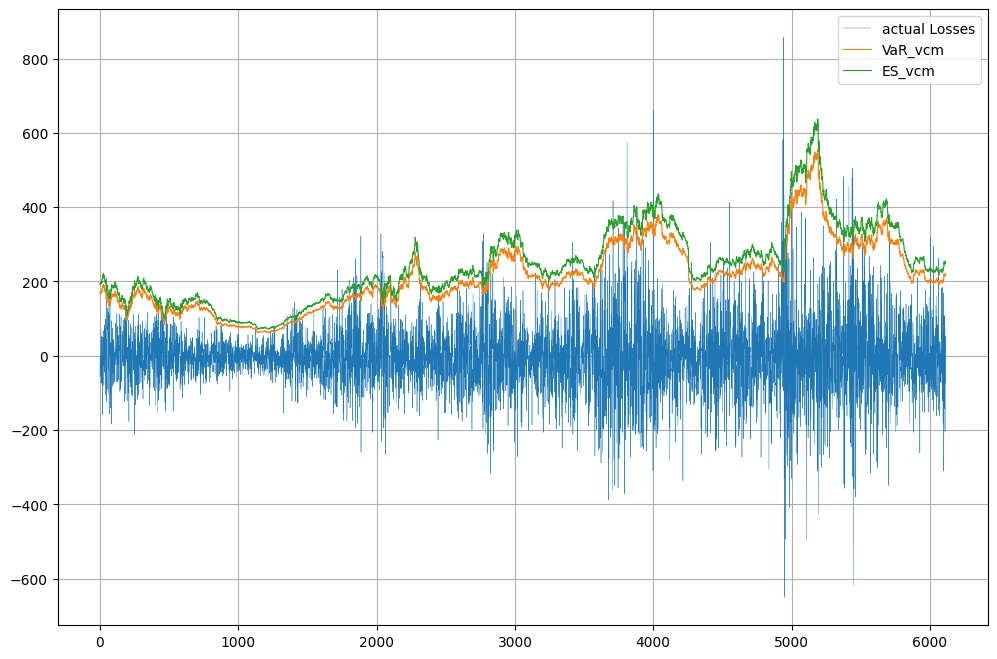

In [41]:
#Plot results
plt.figure(figsize=(12, 8))
plt.plot(losses[td:], label="actual Losses", linewidth=0.3)
# plt.plot(losses_delta[td:], label="lin. Losses", linewidth=0.3)

# Risk measures
plt.plot(VaR_vcm, label="VaR_vcm", linewidth=0.8)
plt.plot(ES_vcm, label="ES_vcm", linewidth=0.8)

plt.legend()
plt.grid()
plt.show()

**Task 3.6**: Compute the fraction of time points at which the actually incurred loss stored in the array `losses` exceeds the VaR estimate stored in the array `VaR`. Interpret your result.

In [42]:
ex_losses = np.mean(losses[td:] > VaR_vcm[:-1])
print(f"{round(ex_losses * 100, 2)}%")

1.83%


In [43]:
ex_lin_losses = np.mean(losses_delta[td:] > VaR_vcm[:-1])
print(f"{round(ex_lin_losses * 100, 2)}%")

1.93%


**Task 3.7**: Compute the linearised losses $L^\Delta_{n+1} = -\sum_{i=1}^5 \alpha_i S_{n, i} X_{n + 1, i}$ for $n \geq 252$ and store them in an array `lin_losses`. Compute the fraction of time points at which the linearised loss stored in the array `lin_losses` exceeds the VaR estimate stored in the array `VaR`. Interpret your result.

*Useful Python commands*: `np.dot`

In [44]:
lin_losses = "..."
# see code above